In [1]:
using DataFrames
using Gadfly
using Chemfiles
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [3]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

function WeightedHist(in_vec, in_bins, in_weight, density = true, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    const n_x = length(in_bins)
    out_counts = zeros(n_x-1)
    
    if include_bounds
        for i in 1:length(in_vec)
            x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                x = n_x - 1
            end
            
            out_counts[x] += in_weight[i]
        end
    else
        for i in 1:length(in_vec)
            const x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                continue
            elseif x == 1 && isless(in_bins[x], in_vec[i])
                continue
            end

            out_counts[x] += in_weight[i]
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    
    return out_counts, out_middle
end

WeightedHist (generic function with 3 methods)

In [4]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64, aa3 / 3)

133

### Leo el RMSD respecto al avg

In [29]:
rmsd_vol0 = readdlm(joinpath(home, pdb, "poblaciones", "intra", string("rmsd_vol0")))[:, 2]
rmsd_vol1 = readdlm(joinpath(home, pdb, "poblaciones", "intra", string("rmsd_vol1")))[:, 2]
rmsd_vol2 = readdlm(joinpath(home, pdb, "poblaciones", "intra", string("rmsd_vol2")))[:, 2];

### Guardo el frame más similar al avg

### RMSD 
### intra

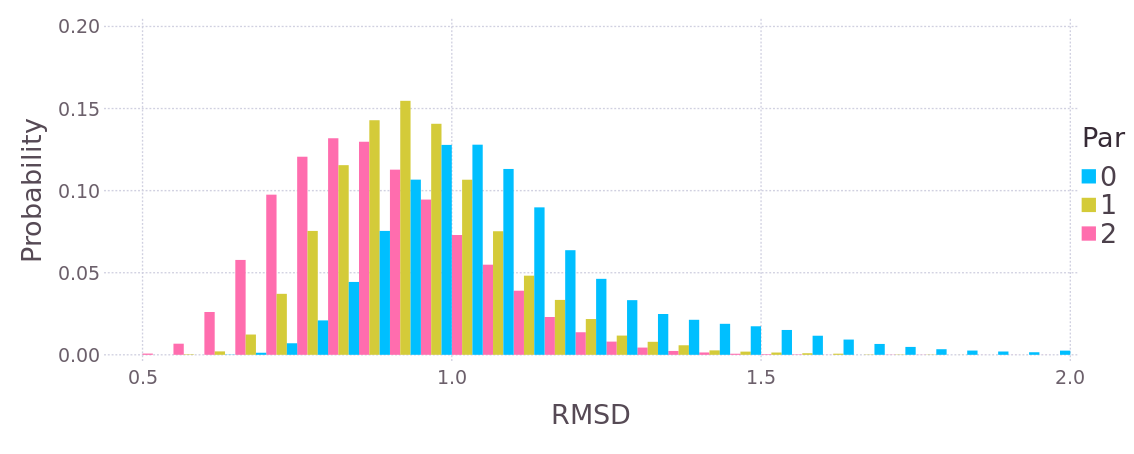

In [141]:
bin_rms = collect(0.5:.05:2.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_vol0, bin_rms, fill(1., length(rmsd_vol0)), true);
his_1, bin_1 = WeightedHist(rmsd_vol1, bin_rms, fill(1., length(rmsd_vol1)), true);
his_2, bin_2 = WeightedHist(rmsd_vol2, bin_rms, fill(1., length(rmsd_vol2)), true);

df_his_rms = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    RMSD = [ bin_0 ; bin_1 ; bin_2 ],
    Par = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

pdf_his_rms = plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [31]:
DataFrame(MEAN = [ mean(rmsd_vol0) ; mean(rmsd_vol1) ; mean(rmsd_vol2) ],
    STD = [ std(rmsd_vol0) ; std(rmsd_vol1) ; std(rmsd_vol2) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN     │ STD      │
├─────┼──────────┼──────────┤
│ 1   │ 1.03954  │ 0.21266  │
│ 2   │ 0.901953 │ 0.143359 │
│ 3   │ 0.838023 │ 0.152359 │

## RMSD
### inter

In [33]:
### Volume 0 vs Volume 1
proto_rmsd_0_1 = readdlm(joinpath(home, pdb, "poblaciones", "inter", "rms2_0_1_4xcp"))[:, 2:end]
rmsd_0_1 = reshape(proto_rmsd_0_1, length(proto_rmsd_0_1))

### Volume 0 vs Volume 2
proto_rmsd_0_2 = readdlm(joinpath(home, pdb, "poblaciones", "inter", "rms2_0_2_4xcp"))[:, 2:end]
rmsd_0_2 = reshape(proto_rmsd_0_2, length(proto_rmsd_0_2))

### Volume 1 vs Volume 2
proto_rmsd_1_2 = readdlm(joinpath(home, pdb, "poblaciones", "inter", "rms2_1_2_4xcp"))[:, 2:end];
rmsd_1_2 = reshape(proto_rmsd_1_2, length(proto_rmsd_1_2));

In [34]:
# Histograma ponderado
bin_rms = collect(.5:.1:4.)
his_0_1, bin_0_1 = WeightedHist(rmsd_0_1, bin_rms, fill(1., length(rmsd_0_1)), true);
his_0_2, bin_0_2 = WeightedHist(rmsd_0_2, bin_rms, fill(1., length(rmsd_0_2)), true);
his_1_2, bin_1_2 = WeightedHist(rmsd_1_2, bin_rms, fill(1., length(rmsd_1_2)), true);

df_his_rms = DataFrame(Probability = [ his_0_1 ; his_0_2 ; his_1_2 ],
    RMSD = [ bin_0_1 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("0_1", length(his_0_1)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

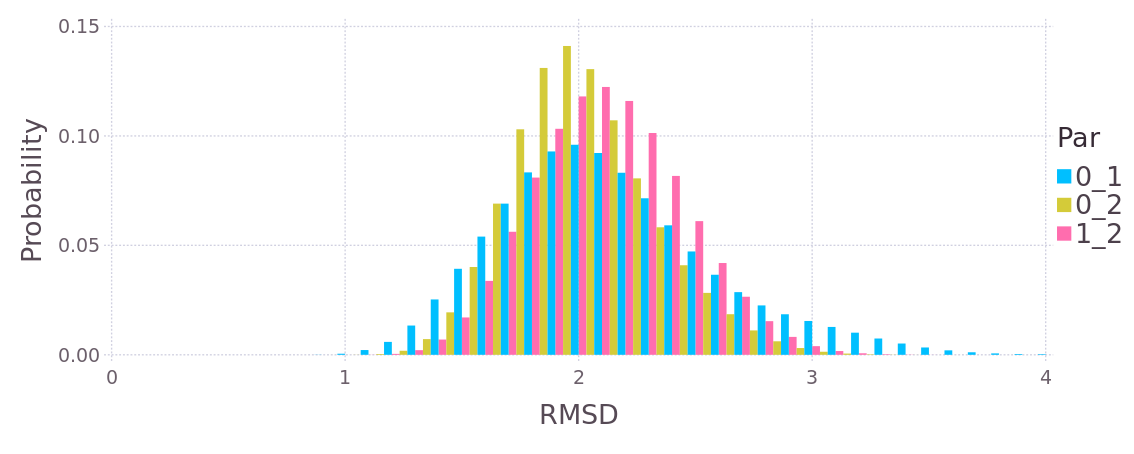

In [35]:
pdf_his_rms = plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [36]:
DataFrame(MEAN = [ mean(rmsd_0_1) ; mean(rmsd_0_2) ; mean(rmsd_1_2) ],
    STD = [ std(rmsd_0_1) ; std(rmsd_0_2) ; std(rmsd_1_2) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD      │
├─────┼─────────┼──────────┤
│ 1   │ 1.97321 │ 0.460505 │
│ 2   │ 1.91696 │ 0.302202 │
│ 3   │ 2.07863 │ 0.318053 │

# RMSDs intra e inter.
##### La misma info de los 2 gráficos anteriorres, pero reordenada

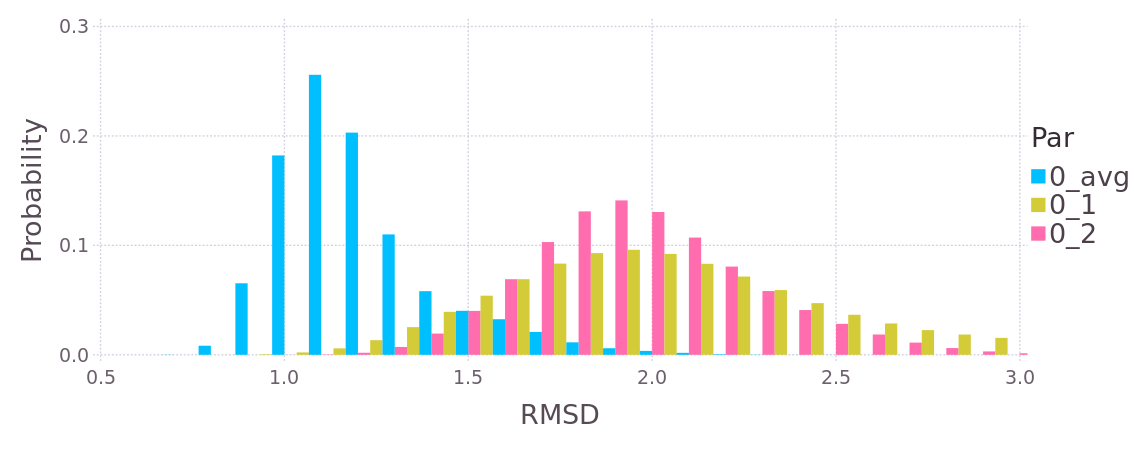

In [142]:
bin_rms = collect(0.5:.1:4.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_vol0, bin_rms, fill(1., length(rmsd_vol0)), true);
his_1, bin_1 = WeightedHist(rmsd_vol1, bin_rms, fill(1., length(rmsd_vol1)), true);
his_2, bin_2 = WeightedHist(rmsd_vol2, bin_rms, fill(1., length(rmsd_vol2)), true);

df_his_rms_0 = DataFrame(Probability = [ his_0 ; his_0_1 ; his_0_2 ; ],
    RMSD = [ bin_0 ; bin_0_1 ; bin_0_2 ],
    Par = [ fill("0_avg", length(his_0)) ;
        fill("0_1", length(his_0_1)) ; fill("0_2", length(his_0_2)) ]);

pdf_his_rms_0 = plot(df_his_rms_0, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

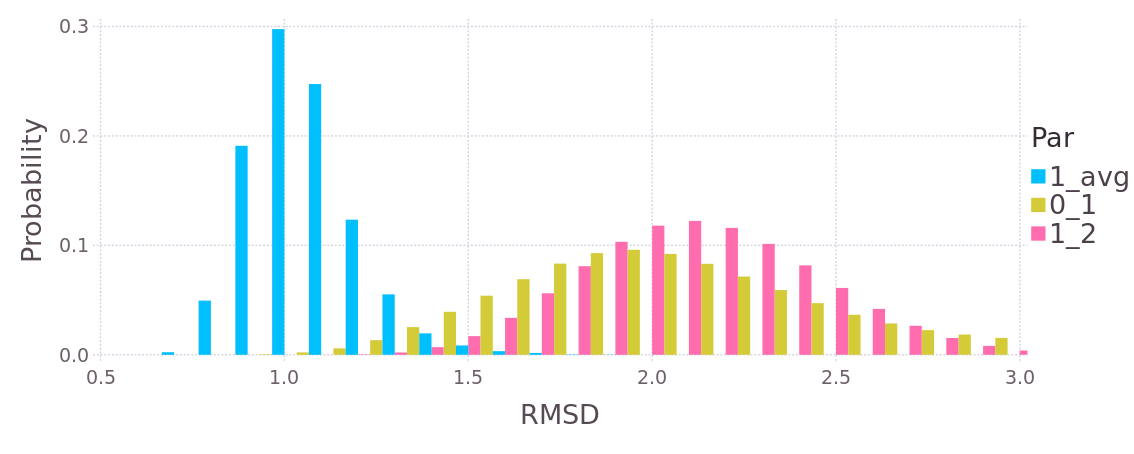

In [41]:
df_his_rms_1 = DataFrame(Probability = [ his_1 ; his_0_1 ; his_1_2 ; ],
    RMSD = [ bin_1 ; bin_0_1 ; bin_1_2 ],
    Par = [ fill("1_avg", length(his_1)) ;
        fill("0_1", length(his_0_1)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_1 = plot(df_his_rms_1, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

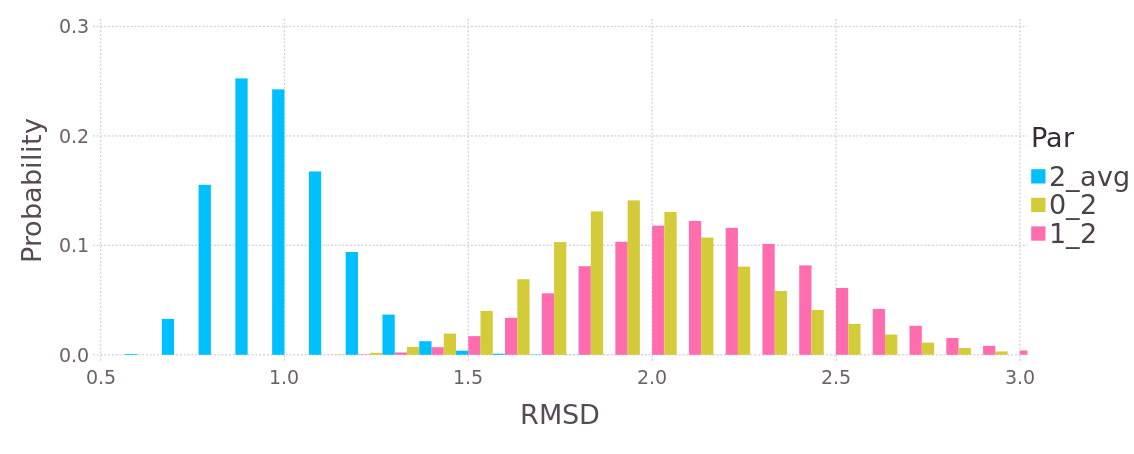

In [42]:
df_his_rms_2 = DataFrame(Probability = [ his_2 ; his_0_2 ; his_1_2 ; ],
    RMSD = [ bin_2 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("2_avg", length(his_2)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_2 = plot(df_his_rms_2, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

# Pocket

### RMSD
### intra

In [136]:
rms_poc_0_aa = readdlm(joinpath(home, pdb, "poblaciones", "pocket", "intra", "rms_vol0_poc_aa"))[:, 2]
rms_poc_0_ca = readdlm(joinpath(home, pdb, "poblaciones", "pocket", "intra", "rms_vol0_poc_ca"))[:, 2]

rms_poc_1_aa = readdlm(joinpath(home, pdb, "poblaciones", "pocket", "intra", "rms_vol1_poc_aa"))[:, 2]
rms_poc_1_ca = readdlm(joinpath(home, pdb, "poblaciones", "pocket", "intra", "rms_vol1_poc_ca"))[:, 2]

rms_poc_2_aa = readdlm(joinpath(home, pdb, "poblaciones", "pocket", "intra", "rms_vol2_poc_aa"))[:, 2]
rms_poc_2_ca = readdlm(joinpath(home, pdb, "poblaciones", "pocket", "intra", "rms_vol2_poc_ca"))[:, 2];

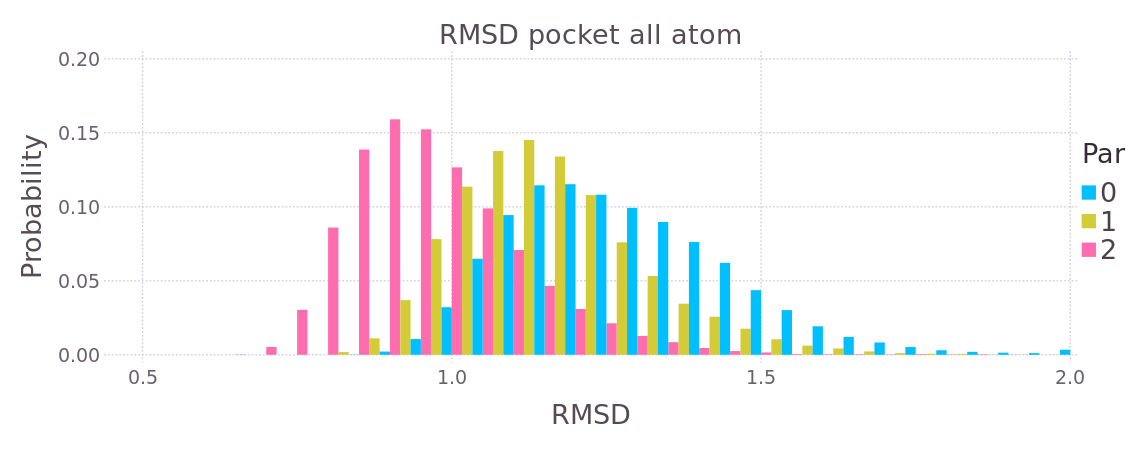

In [140]:
bin_rms = collect(0.5:.05:2.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rms_poc_0_aa, bin_rms, fill(1., length(rms_poc_0_aa)), true);
his_1, bin_1 = WeightedHist(rms_poc_1_aa, bin_rms, fill(1., length(rms_poc_1_aa)), true);
his_2, bin_2 = WeightedHist(rms_poc_2_aa, bin_rms, fill(1., length(rms_poc_2_aa)), true);

df_his_poc_rms = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    RMSD = [ bin_0 ; bin_1 ; bin_2 ],
    Par = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

plot(df_his_poc_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD pocket all atom"),

    Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [145]:
DataFrame(MEAN = [ mean(rms_poc_0_aa) ; mean(rms_poc_1_aa) ; mean(rms_poc_2_aa) ],
    STD = [ std(rms_poc_0_aa) ; std(rms_poc_1_aa) ; std(rms_poc_2_aa) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN     │ STD      │
├─────┼──────────┼──────────┤
│ 1   │ 1.20193  │ 0.178605 │
│ 2   │ 1.10866  │ 0.148843 │
│ 3   │ 0.947311 │ 0.140224 │

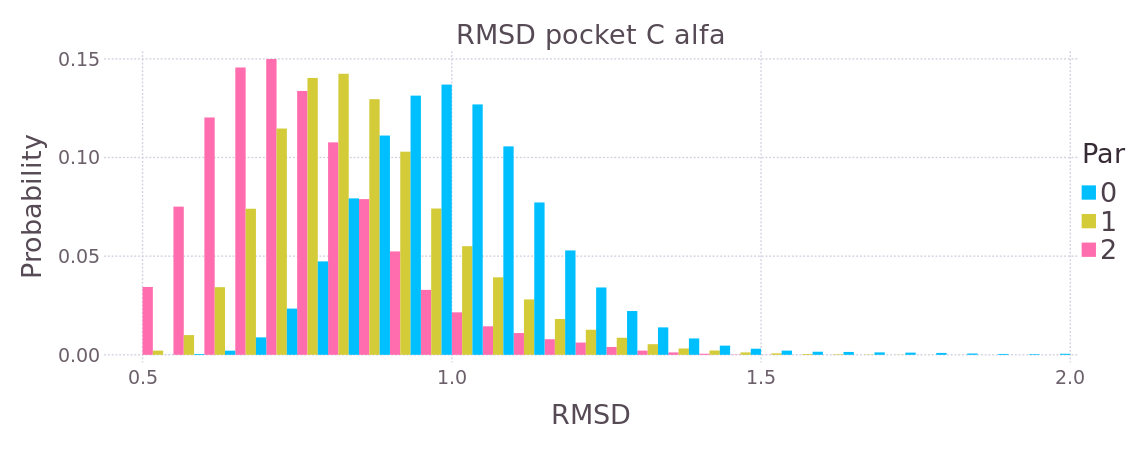

In [144]:
bin_rms = collect(0.5:.05:2.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rms_poc_0_ca, bin_rms, fill(1., length(rms_poc_0_ca)), true);
his_1, bin_1 = WeightedHist(rms_poc_1_ca, bin_rms, fill(1., length(rms_poc_1_ca)), true);
his_2, bin_2 = WeightedHist(rms_poc_2_ca, bin_rms, fill(1., length(rms_poc_2_ca)), true);

df_his_poc_rms = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    RMSD = [ bin_0 ; bin_1 ; bin_2 ],
    Par = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

plot(df_his_poc_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD pocket C alfa"),

    Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),

    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [147]:
DataFrame(MEAN = [ mean(rms_poc_0_ca) ; mean(rms_poc_1_ca) ; mean(rms_poc_2_ca) ],
    STD = [ std(rms_poc_0_ca) ; std(rms_poc_1_ca) ; std(rms_poc_2_ca) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN     │ STD      │
├─────┼──────────┼──────────┤
│ 1   │ 0.95002  │ 0.162409 │
│ 2   │ 0.815771 │ 0.15581  │
│ 3   │ 0.712696 │ 0.148229 │

In [149]:
# all atom
### Volume 0 vs Volume 1
proto_rms_poc_aa_0_1 = readdlm(joinpath(
        home, pdb, "poblaciones", "pocket", "inter", "rms2_0_1_4xcp_poc_aa"))[:, 2:end]
rms_poc_aa_0_1 = reshape(proto_rms_poc_aa_0_1, length(proto_rms_poc_aa_0_1))

### Volume 0 vs Volume 1
proto_rms_poc_aa_0_2 = readdlm(joinpath(
        home, pdb, "poblaciones", "pocket", "inter", "rms2_0_2_4xcp_poc_aa"))[:, 2:end]
rms_poc_aa_0_2 = reshape(proto_rms_poc_aa_0_2, length(proto_rms_poc_aa_0_2))

### Volume 0 vs Volume 1
proto_rms_poc_aa_1_2 = readdlm(joinpath(
        home, pdb, "poblaciones", "pocket", "inter", "rms2_1_2_4xcp_poc_aa"))[:, 2:end]
rms_poc_aa_1_2 = reshape(proto_rms_poc_aa_1_2, length(proto_rms_poc_aa_1_2));

# carbon alpha
### Volume 0 vs Volume 1
proto_rms_poc_ca_0_1 = readdlm(joinpath(
        home, pdb, "poblaciones", "pocket", "inter", "rms2_0_1_4xcp_poc_ca"))[:, 2:end]
rms_poc_ca_0_1 = reshape(proto_rms_poc_ca_0_1, length(proto_rms_poc_ca_0_1))

### Volume 0 vs Volume 1
proto_rms_poc_ca_0_2 = readdlm(joinpath(
        home, pdb, "poblaciones", "pocket", "inter", "rms2_0_2_4xcp_poc_ca"))[:, 2:end]
rms_poc_ca_0_2 = reshape(proto_rms_poc_ca_0_2, length(proto_rms_poc_ca_0_2))

### Volume 0 vs Volume 1
proto_rms_poc_ca_1_2 = readdlm(joinpath(
        home, pdb, "poblaciones", "pocket", "inter", "rms2_1_2_4xcp_poc_ca"))[:, 2:end]
rms_poc_ca_1_2 = reshape(proto_rms_poc_ca_1_2, length(proto_rms_poc_ca_1_2));

11927100-element Array{Float64,1}:
 1.953
 1.897
 2.201
 2.012
 1.888
 1.839
 1.832
 1.967
 1.827
 2.227
 2.161
 2.242
 2.008
 ⋮    
 1.798
 2.188
 1.739
 2.206
 1.873
 1.716
 2.193
 1.84 
 2.169
 1.997
 1.965
 2.118

In [155]:
# all atom
bin_rms = collect(.5:.1:4.)
his_0_1, bin_0_1 = WeightedHist(rms_poc_aa_0_1, bin_rms, fill(1., length(rms_poc_aa_0_1)), true);
his_0_2, bin_0_2 = WeightedHist(rms_poc_aa_0_2, bin_rms, fill(1., length(rms_poc_aa_0_2)), true);
his_1_2, bin_1_2 = WeightedHist(rms_poc_aa_1_2, bin_rms, fill(1., length(rms_poc_aa_1_2)), true);

df_his_rms_poc_aa = DataFrame(Probability = [ his_0_1 ; his_0_2 ; his_1_2 ],
    RMSD = [ bin_0_1 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("0_1", length(his_0_1)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

# carbon alpha
his_0_1, bin_0_1 = WeightedHist(rms_poc_ca_0_1, bin_rms, fill(1., length(rms_poc_ca_0_1)), true);
his_0_2, bin_0_2 = WeightedHist(rms_poc_ca_0_2, bin_rms, fill(1., length(rms_poc_ca_0_2)), true);
his_1_2, bin_1_2 = WeightedHist(rms_poc_ca_1_2, bin_rms, fill(1., length(rms_poc_ca_1_2)), true);

df_his_rms_poc_ca = DataFrame(Probability = [ his_0_1 ; his_0_2 ; his_1_2 ],
    RMSD = [ bin_0_1 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("0_1", length(his_0_1)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

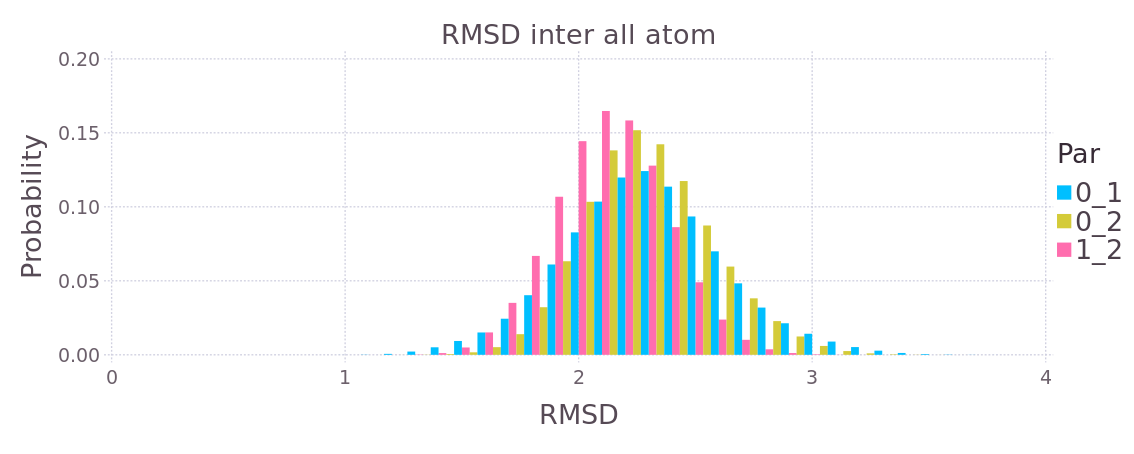

In [158]:
plot(df_his_rms_poc_aa, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD inter all atom"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

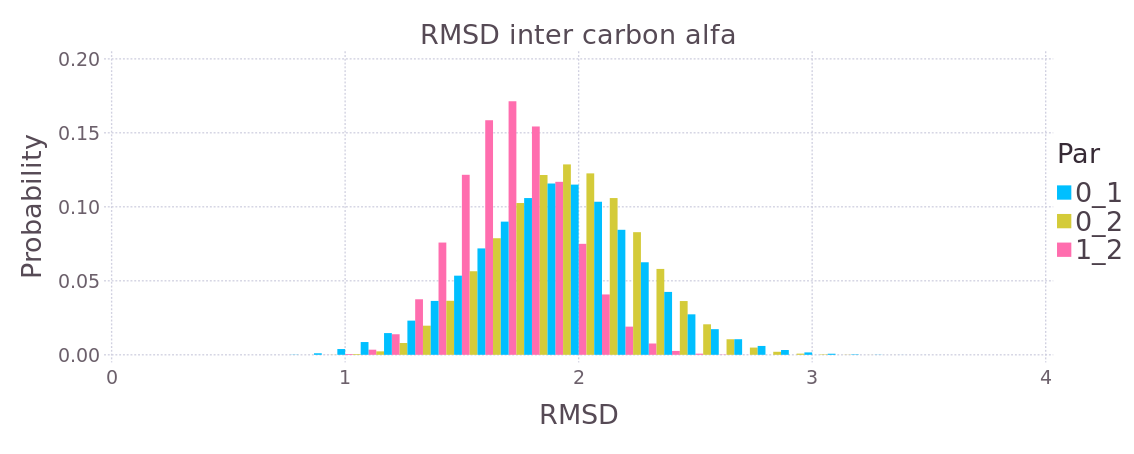

In [159]:
plot(df_his_rms_poc_ca, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD inter carbon alfa"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

# Volumen y RMSD

In [128]:
# Leo volumen
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo RMSD de prote entera
rmsd_4xcp = readdlm(joinpath(home, pdb, "data", string("rmsd_", pdb)))[:, 2];
# Smooth
smooth_rms = [ mean(rmsd_4xcp[i:i+9]) for i = 1:10:length(rmsd_4xcp)-9 ]

# RMSD de pocket
rms_poc_aa = readdlm(joinpath(home, pdb, "pocket", "rms_4xcp_aa"))[:, 2]
rms_poc_bb = readdlm(joinpath(home, pdb, "pocket", "rms_4xcp_bb"))[:, 2]
rms_poc_ca = readdlm(joinpath(home, pdb, "pocket", "rms_4xcp_ca"))[:, 2];
#Smooth
smooth_rms_poc_aa = [ mean(rms_poc_aa[i:i+9]) for i = 1:10:length(rms_poc_aa)-9 ]
smooth_rms_poc_bb = [ mean(rms_poc_bb[i:i+9]) for i = 1:10:length(rms_poc_bb)-9 ]
smooth_rms_poc_ca = [ mean(rms_poc_ca[i:i+9]) for i = 1:10:length(rms_poc_ca)-9 ];

In [ ]:
smooth_rms_poc_aa = [ mean(rms_poc_aa[i:i+9]) for i = 1:10:length(rms_poc_aa)-9 ]
smooth_rms_poc_bb = [ mean(rms_poc_bb[i:i+9]) for i = 1:10:length(rms_poc_bb)-9 ]
smooth_rms_poc_ca = [ mean(rms_poc_ca[i:i+9]) for i = 1:10:length(rms_poc_ca)-9 ];

df_smooth_rmsd_poc = DataFrame(RMSD = [ smooth_rms_poc_aa ; smooth_rms_poc_bb ; smooth_rms_poc_ca ],
    Frame = repeat(collect(1:length(smooth_rms_poc_ca)), outer = 3),
    Mask = repeat(["AA" ; "BB" ; "CA"], inner = length(smooth_rms_poc_ca)));

plot(df_smooth_rmsd_poc, x = "Frame", y = "RMSD", color = "Mask",
    Geom.line,
    Guide.title("RMSD de pocket"),

    #Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

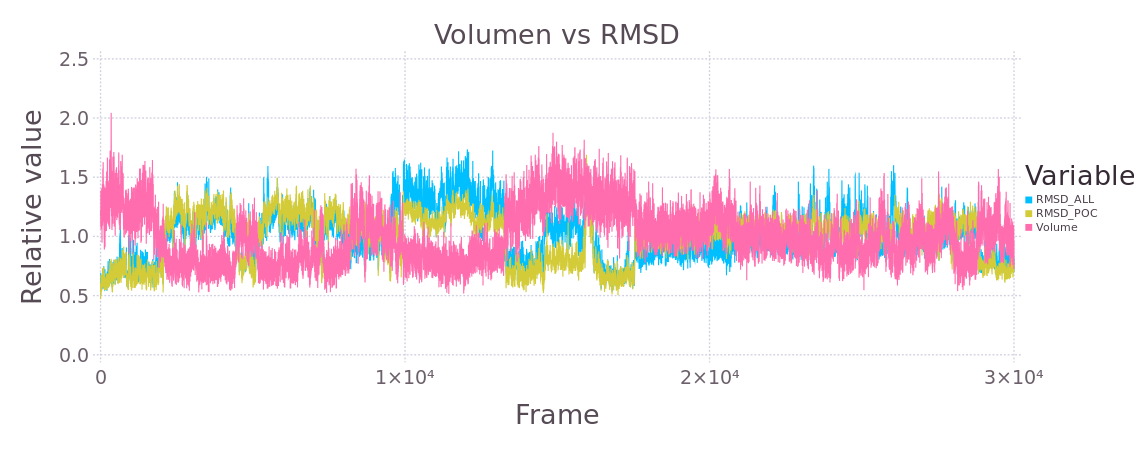

In [129]:
df_vol_rms = DataFrame(
    Value = [smooth_rms ./ mean(smooth_rms) ;
        smooth_rms_poc_ca ./ mean(smooth_rms_poc_ca) ; trj_vol ./ mean(trj_vol) ; ],
    Frame = repeat(collect(1:length(trj_vol)), outer = 3), 
    Variable = repeat(["RMSD_ALL" ; "RMSD_POC" ; "Volume"], inner = length(trj_vol)));

plot(df_vol_rms, x = "Frame", y = "Value", color = "Variable",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    Guide.title("Volumen vs RMSD"),

    #Coord.cartesian(xmin = 0, xmax = 3E4, ymin = 200, ymax = 1800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("Relative value", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [130]:
[ cor(smooth_rms, trj_vol) ; cor(smooth_rms_poc_ca, trj_vol) ]

2-element Array{Float64,1}:
 -0.537149
 -0.641466

In [6]:
# Leo índices de las 3 poblaciones
idx_vol0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb,"_idx_vol0")))[:, 1])
idx_vol1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb,"_idx_vol1")))[:, 1])
idx_vol2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb,"_idx_vol2")))[:, 1]);

# Guardo el nro de frames en c/ población
nframes_0 = length(idx_vol0)
nframes_1 = length(idx_vol1)
nframes_2 = length(idx_vol2)

# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_vol0]
trj_vol1 = full_trj_vol[idx_vol1]
trj_vol2 = full_trj_vol[idx_vol2];

LoadError: [91mUndefVarError: trj_vol not defined[39m

# Lig

In [5]:
const c1 = 2427
const cg = 2444

2444

### Distancia

In [27]:
function limito_scope(c1, cg, in_trj_filename)
    # Uso esto p/ dividir las trayectorias a escribir en 4 partes y q
    # no me llenen la memoria
    in_trj = Trajectory(in_trj_filename)
    nframes = nsteps(in_trj)
    distancias = Array{Float64, 1}(nframes)
    close(in_trj)
    idx_ = convert(Int64, ceil(nframes / 4))
    tmp = [ collect(1:idx_:nframes) ; nframes ]
    
    
    for j in 1:length(tmp) - 1
        if j == 1
            in_trj = Trajectory(in_trj_filename)
            for i in tmp[j]:tmp[j+1]
                in_frm = read_step(in_trj, i - 1)
                distancias[i] = norm(positions(in_frm)[:, c1] - positions(in_frm)[:, cg])
            end
            close(in_trj)
            gc()
        else
            in_trj = Trajectory(in_trj_filename)
            for i in tmp[j]+1:tmp[j+1]
                in_frm = read_step(in_trj, i - 1)
                distancias[i] = norm(positions(in_frm)[:, c1] - positions(in_frm)[:, cg])
            end
            close(in_trj)
            gc()
        end
    end
    return distancias
end

limito_scope (generic function with 2 methods)

In [25]:
dis_lig_vol0 = limito_scope(c1, cg, joinpath(home, pdb, string("poblaciones/vol0", "_", pdb, ".nc")))
dis_lig_vol1 = limito_scope(c1, cg, joinpath(home, pdb, string("poblaciones/vol1", "_", pdb, ".nc")))
dis_lig_vol2 = limito_scope(c1, cg, joinpath(home, pdb, string("poblaciones/vol2", "_", pdb, ".nc")));

1
2
3
4
1
2
3
4


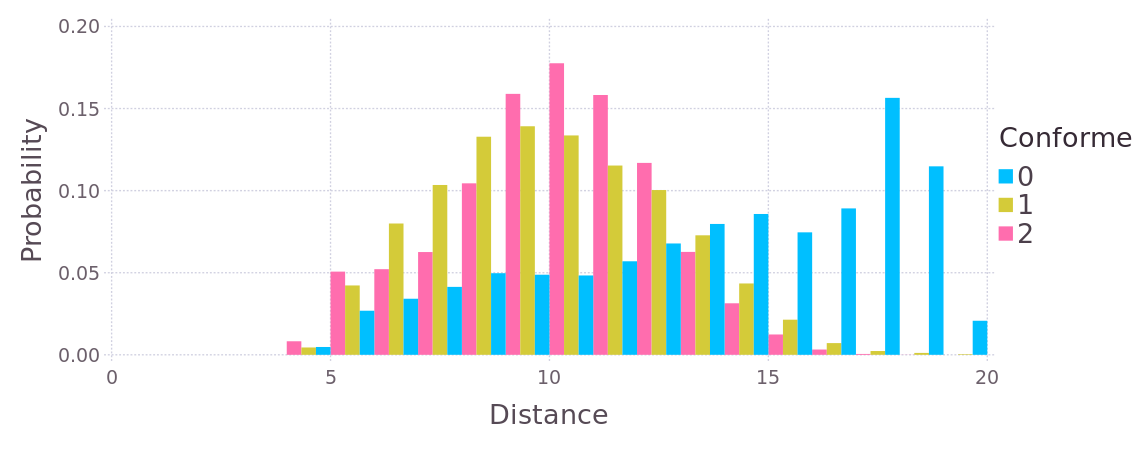

In [26]:
bin_dis = collect(3.:1.:20.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(dis_lig_vol0, bin_dis, fill(1., length(dis_lig_vol0)), true);
his_1, bin_1 = WeightedHist(dis_lig_vol1, bin_dis, fill(1., length(dis_lig_vol1)), true);
his_2, bin_2 = WeightedHist(dis_lig_vol2, bin_dis, fill(1., length(dis_lig_vol2)), true);

df_his_rms_lig = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    Distance = [ bin_0 ; bin_1 ; bin_2 ],
    Conformer = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

pdf_his_rms_lig = plot(df_his_rms_lig, x = "Distance", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

### RMSD
### intra

#### Leo el RMSD respecto al avg

In [38]:
rmsd_lig_vol0 = readdlm(joinpath(home, pdb, "poblaciones", "lig", "intra", "rmsd_vol0_lig"))[:, 2]
rmsd_lig_vol1 = readdlm(joinpath(home, pdb, "poblaciones", "lig", "intra", "rmsd_vol1_lig"))[:, 2]
rmsd_lig_vol2 = readdlm(joinpath(home, pdb, "poblaciones", "lig", "intra", "rmsd_vol2_lig"))[:, 2]

42559

### Guardo el frame más similar al avg

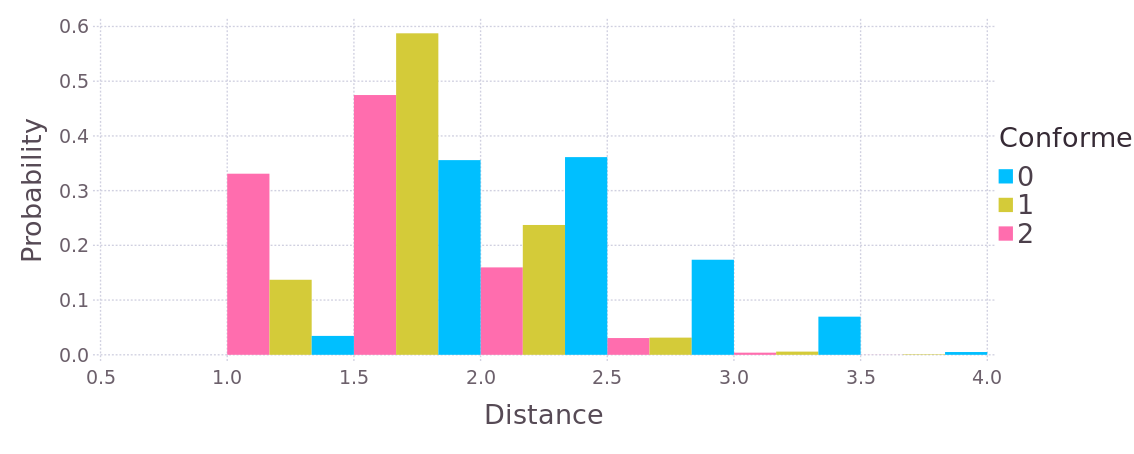

In [137]:
bin_rms = collect(.5:.5:15.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_lig_vol0, bin_rms, fill(1., length(rmsd_lig_vol0)), true);
his_1, bin_1 = WeightedHist(rmsd_lig_vol1, bin_rms, fill(1., length(rmsd_lig_vol1)), true);
his_2, bin_2 = WeightedHist(rmsd_lig_vol2, bin_rms, fill(1., length(rmsd_lig_vol2)), true);

df_his_rms = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    Distance = [ bin_0 ; bin_1 ; bin_2 ],
    Conformer = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

pdf_his_rms = plot(df_his_rms, x = "Distance", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 4.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

### RMSD cruzado

In [177]:
### Volume 0 vs Volume 1
proto_rmsd_0_1_lig = readdlm(joinpath(home, pdb, "poblaciones", "lig", "inter", "rms2_0_1_4xcp_lig"))[:, 2:end]
rmsd_0_1_lig = reshape(proto_rmsd_0_1_lig, length(proto_rmsd_0_1_lig))

### Volume 0 vs Volume 2
proto_rmsd_0_2_lig = readdlm(joinpath(home, pdb, "poblaciones", "lig", "inter", "rms2_0_2_4xcp_lig"))[:, 2:end]
rmsd_0_2_lig = reshape(proto_rmsd_0_2_lig, length(proto_rmsd_0_2_lig));

### Volume 1 vs Volume 2
proto_rmsd_1_2_lig = readdlm(joinpath(home, pdb, "poblaciones", "lig", "inter", "rms2_1_2_4xcp_lig"))[:, 2:end];
rmsd_1_2_lig = reshape(proto_rmsd_1_2_lig, length(proto_rmsd_1_2_lig))
rmsd_1_2_lig = rmsd_1_2_lig[rmsd_1_2_lig .!= 0.];

In [178]:
bin_rms_lig = collect(.5:.5:15)

# Histograma ponderado
his_0_1, bin_0_1 = WeightedHist(rmsd_0_1_lig, bin_rms_lig, fill(1., length(rmsd_0_1_lig)), true);
his_0_2, bin_0_2 = WeightedHist(rmsd_0_2_lig, bin_rms_lig, fill(1., length(rmsd_0_2_lig)), true);
his_1_2, bin_1_2 = WeightedHist(rmsd_1_2_lig, bin_rms_lig, fill(1., length(rmsd_1_2_lig)), true);

df_his_rms = DataFrame(Probability = [ his_0_1 ; his_0_2 ; his_1_2 ],
    RMSD = [ bin_0_1 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("0_1", length(his_0_1)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

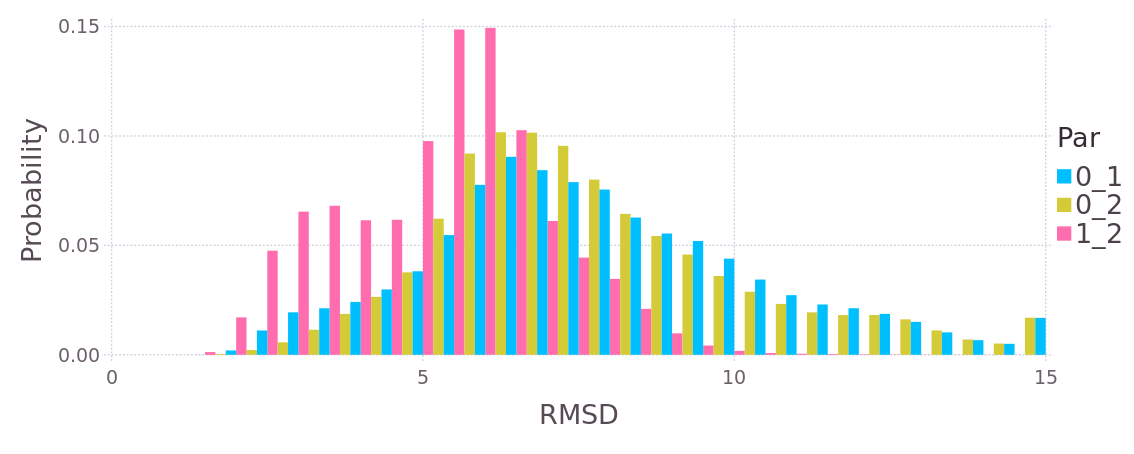

In [179]:
pdf_his_rms = plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 4.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [180]:
DataFrame(MEAN = [ mean(rmsd_0_1_lig) ; mean(rmsd_0_2_lig) ; mean(rmsd_1_2_lig) ],
    STD = [ std(rmsd_0_1_lig) ; std(rmsd_0_2_lig) ; std(rmsd_1_2_lig) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD     │
├─────┼─────────┼─────────┤
│ 1   │ 7.13208 │ 2.74001 │
│ 2   │ 7.18288 │ 2.54555 │
│ 3   │ 5.12005 │ 1.63847 │

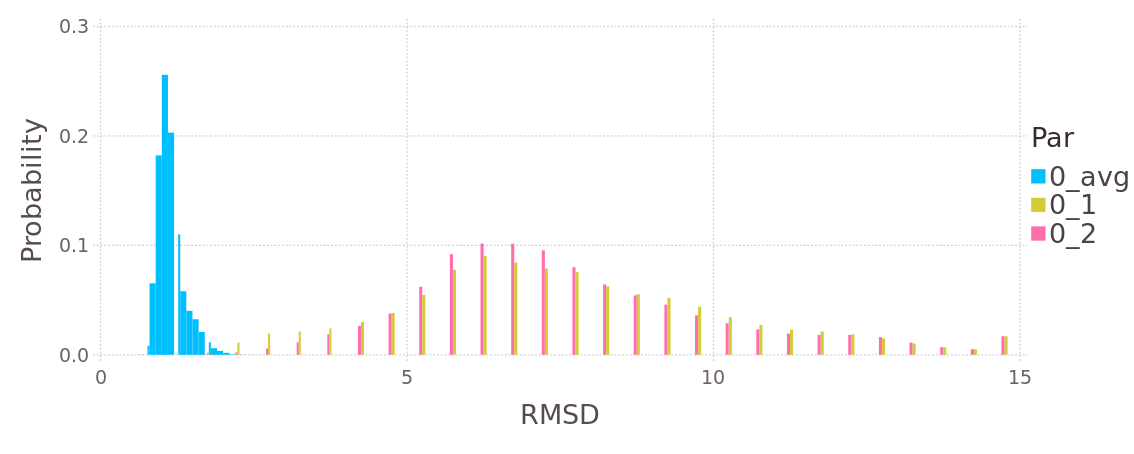

In [181]:
df_his_rms_lig_0 = DataFrame(Probability = [ his_0 ; his_0_1 ; his_0_2 ],
    RMSD = [ bin_0 ; bin_0_1 ; bin_0_2 ],
    Par = [ fill("0_avg", length(his_0)) ;
        fill("0_1", length(his_0_1)) ; fill("0_2", length(his_0_2)) ]);

pdf_his_rms_lig_0 = plot(df_his_rms_lig_0, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

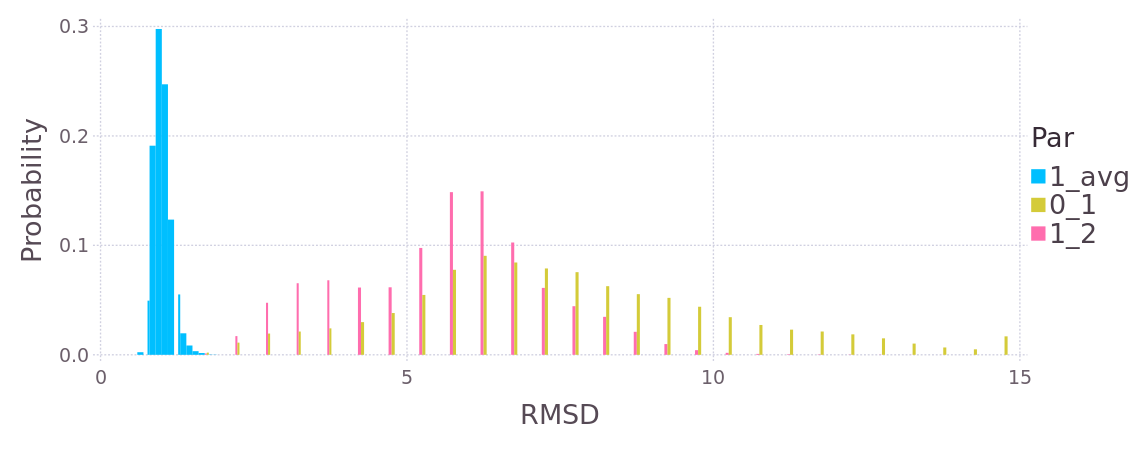

In [182]:
df_his_rms_1_lig = DataFrame(Probability = [ his_1 ; his_0_1 ; his_1_2 ; ],
    RMSD = [ bin_1 ; bin_0_1 ; bin_1_2 ],
    Par = [ fill("1_avg", length(his_1)) ;
        fill("0_1", length(his_0_1)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_1_lig = plot(df_his_rms_1_lig, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

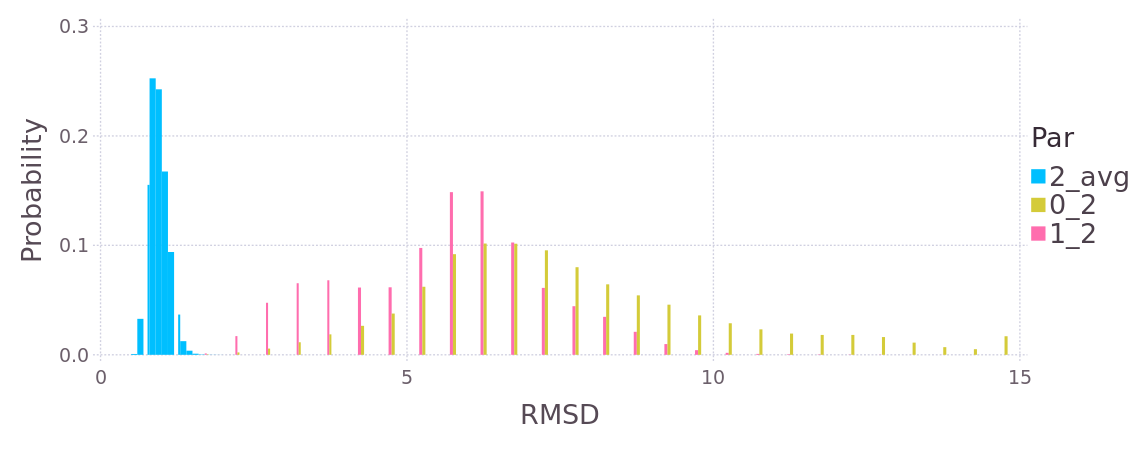

In [183]:
df_his_rms_2_lig = DataFrame(Probability = [ his_2 ; his_0_2 ; his_1_2 ; ],
    RMSD = [ bin_2 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("2_avg", length(his_2)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_2_lig = plot(df_his_rms_2_lig, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))